In [328]:
import re
import os
import bs4
import json
import nltk
import time
import string
import pickle
import requests
import collections
import sklearn.tree
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

In [281]:
ROOT_URL = 'https://en.wikipedia.org/'
DATA_DIR = 'articles'

In [282]:
stop_words = nltk.corpus.stopwords.words('english')

In [5]:
with open('articles.json', 'r') as infile:
    articles_data = json.load(infile)

In [6]:
def get_all_leaves(tree_dict):
    if 'children' not in tree_dict.keys():
        return [tree_dict['id']]
    leaves = []
    for child in tree_dict['children']:
        leaves.extend(get_all_leaves(child))
    return leaves

In [7]:
ROOT_URL + get_all_leaves(articles_data)[0]

'https://en.wikipedia.org//wiki/Julie_Andrews'

In [8]:
def get_articles_by_category(articles):
    categories = {}
    for category in articles['children']:
        categories[category['name']] = get_all_leaves(category)
    return categories

In [9]:
get_articles_by_category(articles_data)

{'People': ['/wiki/Julie_Andrews',
  '/wiki/Lauren_Bacall',
  '/wiki/Amitabh_Bachchan',
  '/wiki/Brigitte_Bardot',
  '/wiki/Ingrid_Bergman',
  '/wiki/Sarah_Bernhardt',
  '/wiki/Humphrey_Bogart',
  '/wiki/Marlon_Brando',
  '/wiki/James_Cagney',
  '/wiki/Jackie_Chan',
  '/wiki/Claudette_Colbert',
  '/wiki/Sean_Connery',
  '/wiki/Gary_Cooper',
  '/wiki/Joan_Crawford',
  '/wiki/Bette_Davis',
  '/wiki/Doris_Day',
  '/wiki/Robert_De_Niro',
  '/wiki/Alain_Delon',
  '/wiki/Marlene_Dietrich',
  '/wiki/Clint_Eastwood',
  '/wiki/Henry_Fonda',
  '/wiki/Jean_Gabin',
  '/wiki/Clark_Gable',
  '/wiki/Greta_Garbo',
  '/wiki/Judy_Garland',
  '/wiki/John_Gielgud',
  '/wiki/Lillian_Gish',
  '/wiki/Cary_Grant',
  '/wiki/Alec_Guinness',
  '/wiki/Tom_Hanks',
  '/wiki/Setsuko_Hara',
  '/wiki/Rita_Hayworth',
  '/wiki/Audrey_Hepburn',
  '/wiki/Katharine_Hepburn',
  '/wiki/Grace_Kelly',
  '/wiki/Klaus_Kinski',
  '/wiki/Vivien_Leigh',
  '/wiki/Sophia_Loren',
  '/wiki/Madhubala',
  '/wiki/Marcello_Mastroianni',
  

In [9]:
def download_articles(articles):
    for label, url_paths in articles.items():
        os.makedirs(os.path.join(DATA_DIR, label))
        for url_path in url_paths:
            time.sleep(0.1)
            request = requests.get(ROOT_URL + url_path)
            if request.status_code == 200:
                html = request.content
                title = os.path.split(url_path)[-1]
                with open(f'{os.path.join(DATA_DIR, label, title)}.html', 'wb') as outfile:
                    outfile.write(html)

In [10]:
download_articles(get_articles_by_category(articles_data))

In [283]:
def extract_text(html):
    soup = bs4.BeautifulSoup(html, 'html.parser')
    content = soup.find('div', id='content').find('div', id='bodyContent').find('div', id='mw-content-text').find('div')
    if content.find(class_='shortdescription'): content.find(class_='shortdescription').decompose()
    if content.find(id='References'): content.find(id='References').decompose()
    if content.find(class_='reflist'): content.find(class_='reflist').decompose()
    for i in content.find_all(class_='mwe-math-element'): i.decompose()
    text = '\n'.join([i.get_text() for i in content if i.name == 'p' or i.name == 'h1' or i.name == 'h2' or i.name == 'h3' or i.name == 'ul'])
    text = text.split('See also[edit]')[0]
    text = re.sub('[\(\[].*?[\)\]]', '', text)
    text = text.lower()
    return text

In [371]:
def digest_articles(directory):
    for article in os.listdir(directory):
        if os.path.splitext(article)[-1] != '.html': continue
        with open(os.path.join(directory, article), 'rb') as infile:
            html = infile.read()
        text = extract_text(html)
        tokens = nltk.tokenize.word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [token for token in tokens if not any([(punc in token) for punc in string.punctuation])]
        counts = collections.Counter(tokens)
        filename = os.path.splitext(article)[0]+'.txt'
        with open(os.path.join(directory, filename), 'w') as outfile:
            outfile.write(f'ALL_WORDS:{sum(counts.values())}\n')
            title = os.path.splitext(article)[0]
            outfile.write(f'TITLE_NUM_WORDS:{len(title.split("_"))}\n')
            for i in range(5):
                if i < len(title.split('_')):
                    w = title.split('_')[i]
                    outfile.write(f'TITLE_WORD_{i}_LEN:{len(w)}\n')
            for word, count in counts.items():
                if count > 1:
                    outfile.write(f'{word}:{count}\n')

In [372]:
categories = [os.path.join(DATA_DIR, category) for category in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, category))]

with multiprocessing.Pool(len(categories)) as p:
    p.map(digest_articles, categories)

In [384]:
def load_word_list(directory):
    words = collections.Counter()
    for category in os.listdir(directory):
        for article in os.listdir(os.path.join(directory, category)):
            if os.path.splitext(article)[-1] != '.txt': continue
            with open(os.path.join(directory, category, article), 'r') as infile:
                data = infile.read()
            for line in data.split('\n'):
                if line == '': continue
                word = line.split(':')[0]
                words[word] += 1
    words_array = np.array([word for word, count in words.items() if count > 5]) # optimized for getting word of index
    words_dict = {word:i for i, word in enumerate(words_array)} # optimized for getting index of word
    return words_array, words_dict

In [385]:
words_array, words_dict = load_word_list('articles')

In [386]:
len(words_array)

39620

In [389]:
with open('words.pkl', 'wb') as outfile:
    pickle.dump([words_array, words_dict], outfile)

In [390]:
with open('words.pkl', 'rb') as infile:
    words_array, words_dict = pickle.load(infile)

In [391]:
def load_features(directory, words_dict):
    features = []
    labels = []
    for category in os.listdir(directory):
        for article in os.listdir(os.path.join(directory, category)):
            if os.path.splitext(article)[-1] != '.txt': continue
            with open(os.path.join(directory, category, article), 'r') as infile:
                data = infile.read()
            vector = [0] * len(words_dict)
            for line in data.split('\n'):
                if line == '': continue
                word, count = line.split(':')
                count = int(count)
                if word not in words_dict.keys(): continue
                vector[words_dict[word]] = count
            features.append(vector)
            labels.append(category)
    return np.array(features), np.array(labels)

In [392]:
features, labels = load_features('articles', words_dict)

In [393]:
with open('features.pkl', 'wb') as outfile:
    pickle.dump([features, labels], outfile)

In [394]:
with open('features.pkl', 'rb') as infile:
    features, labels = pickle.load(infile)

In [395]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 10) #, class_weight='balanced')

In [396]:
classifier.fit(features, labels)

DecisionTreeClassifier(max_depth=10)

In [397]:
classifier.score(features, labels)

0.6752572170612327

In [398]:
top_features = np.argsort(classifier.feature_importances_)[::-1][:100]
print(classifier.feature_importances_[top_features])
print(np.array(words)[top_features])

[0.17081934 0.10424066 0.10355023 0.04307196 0.0400047  0.03027268
 0.02723052 0.02667301 0.02536085 0.02351576 0.02242559 0.01886529
 0.01790678 0.01700023 0.0157563  0.01448223 0.01166659 0.01102744
 0.01088965 0.00898566 0.00897965 0.00811651 0.0077545  0.00736
 0.0060658  0.00593655 0.00559204 0.00553587 0.00519202 0.00466111
 0.00460368 0.00391664 0.00381936 0.00323562 0.00318629 0.00315463
 0.00305715 0.00295685 0.00292172 0.00257761 0.0025656  0.00255526
 0.00235237 0.00234857 0.00224082 0.00222723 0.00220142 0.00216212
 0.00206459 0.00203659 0.00198466 0.00197827 0.00191343 0.00185254
 0.00183727 0.00183461 0.00175078 0.00174614 0.00169246 0.00168904
 0.00165929 0.00165268 0.00163242 0.0015852  0.00158276 0.00156617
 0.00156213 0.00155826 0.00155525 0.00149554 0.00146171 0.0014485
 0.00144806 0.00143219 0.00141386 0.00138461 0.00136401 0.00133308
 0.00132857 0.00130814 0.00130797 0.00122589 0.0012094  0.00119606
 0.00116134 0.00115987 0.0011585  0.00113781 0.00113631 0.00110271

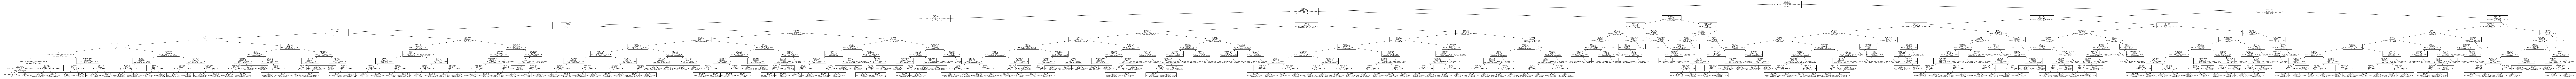

In [403]:
plt.figure(figsize=(512,16))
sklearn.tree.plot_tree(classifier, fontsize=10, feature_names=words_array, class_names=classifier.classes_)
plt.show()